# 06. PyTorch Transfer Learning

1. What is transfer learning?
- Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.
- For example, we can take the patterns a computer vision model has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our FoodVision Mini model.

## 0. Getting setup

In [3]:
import torch 
import torchvision 
import matplotlib.pyplot as plt 

from torch import nn 
from torchvision import transforms

try:
    from torchinfo import summary 
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try: 
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .  # Takes the going_modular folder from inside pytorch-deep-learning/ .Moves it to the current directory
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

torch.__version__, torchvision.__version__

('2.7.1+cu118', '0.22.1+cu118')

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
import os 
import zipfile 
import requests
from pathlib import Path 

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

2.1 Creating a transform for torchvision.models (manual creation)
- When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.
- Prior to torchvision v0.13+, to create a transform for a pretrained model in torchvision.models, the documentation stated:
- All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
- The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

<img src="TransferLearning.png"/>

In [8]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [9]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x279dc862870>,
 ['pizza', 'steak', 'sushi'])

#### 2.2 Creating a transform for torchvision.models (auto creation)
- As previously stated, when using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.
- When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
- Where:
    - EfficientNet_B0_Weights is the model architecture weights we'd like to use (there are many different model architecture options in torchvision.models).
    - DEFAULT means the best available weights (the best performance in ImageNet) (Note: Depending on the model architecture you choose, you may also see other options such as IMAGENET_V1 and IMAGENET_V2 where generally the higher version number the better. Though if you want the best available, DEFAULT is the easiest option)

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

- And now to access the transforms associated with our weights, we can use the transforms() method.

- This is essentially saying "get the data transforms that were used to train the EfficientNet_B0_Weights on ImageNet".

- The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

- However, the tradeoff of using automatically created transforms is a lack of customization.

In [11]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=auto_transforms,
                                                                              batch_size=32)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x279dc4e11f0>,
 <torch.utils.data.dataloader.DataLoader at 0x279dccc1b20>)

## 3. Getting a pretrained model
<img src="PModels.png"/>

### 3.2 Setting up a pretrained model

In [13]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\16133/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:02<00:00, 9.16MB/s]


### 3.3 Getting a summary of our model with torchinfo.summary()

In [31]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs
- We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False.

In [35]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False
    

In [36]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [37]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

In [38]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

In [39]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [40]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 

start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                       epochs=5,
                       device=device
                      )

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9132 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8718 | train_acc: 0.7773 | test_loss: 0.7911 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6372 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 232.355 seconds


## 5. Evaluate model by plotting loss curves

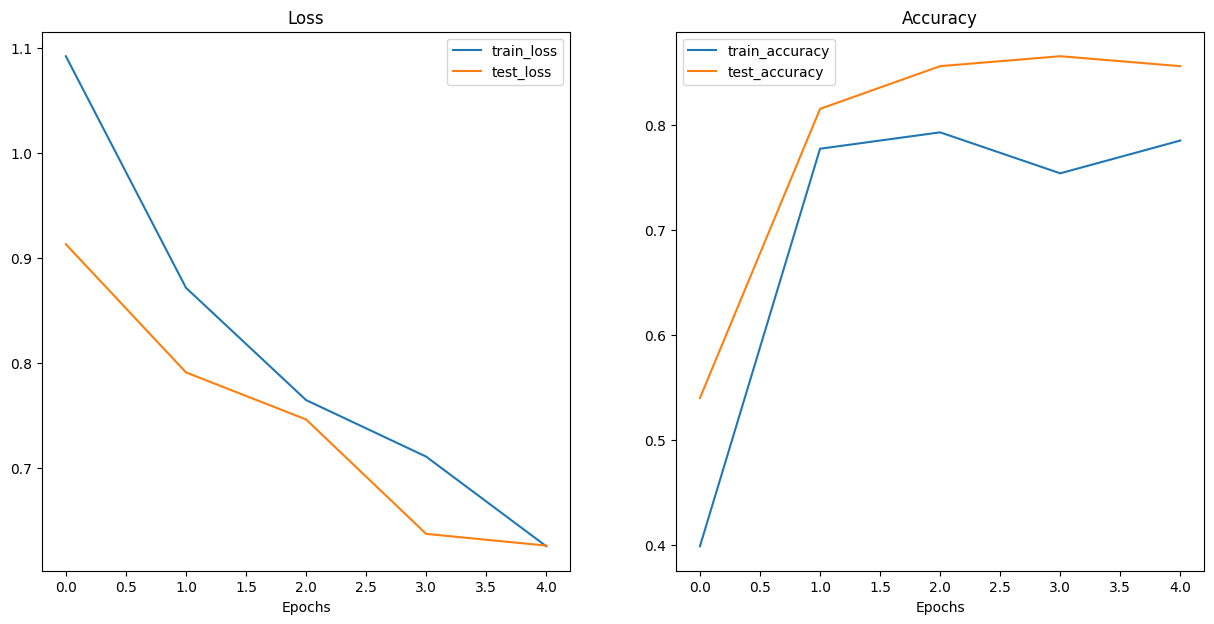

In [41]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves
# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [42]:
from typing import Tuple, List 
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                       img_path: str,
                       class_names: List[str],
                       image_size: Tuple[int, int] = (224, 224),
                       transform: torchvision.transforms = None,
                       device: torch.device = device):
    # 2. Open image
    img = Image.open(img_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform 
    else: 
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

    ### Predict on image ### 

    model.to(device)

    model.eval()

    with torch.inference_mode():
        transformed_img = image_transform(img).unsqueeze(dim=0)

        target_image_pred = model(transformed_img.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure(figsize=(15 , 7))
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

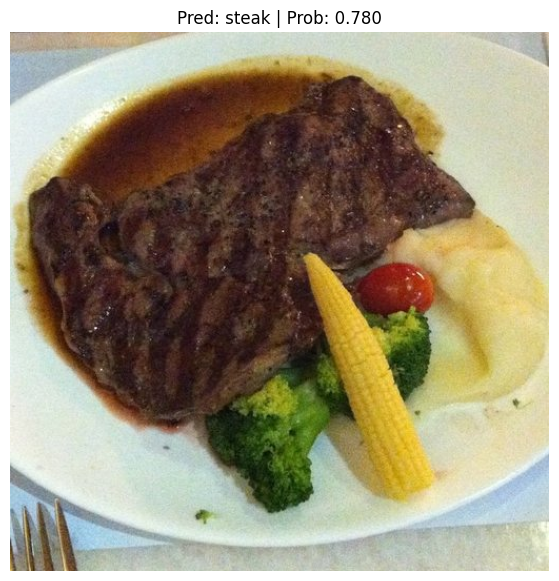

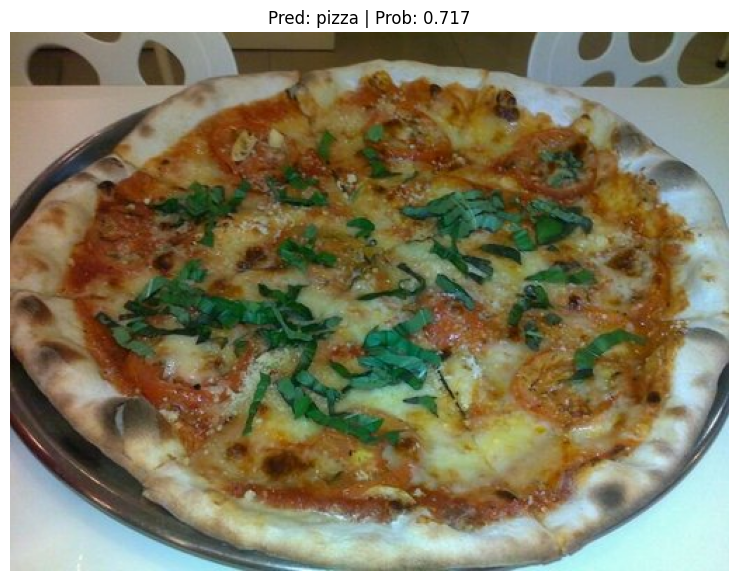

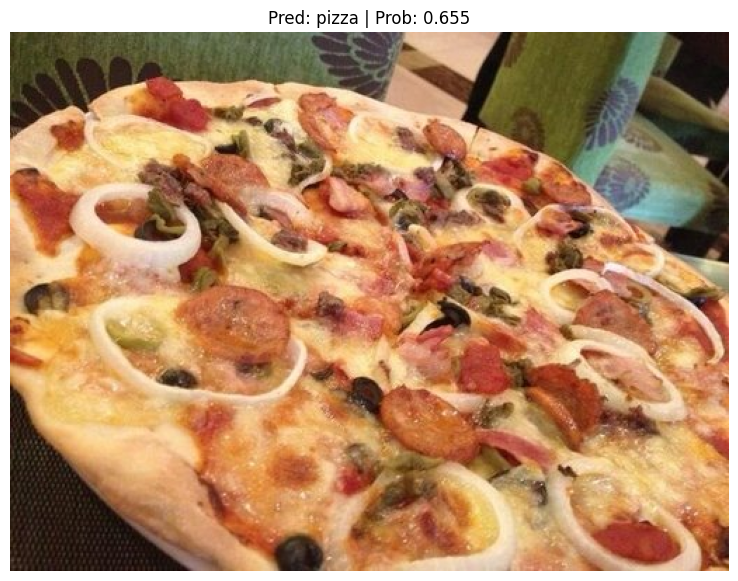

In [45]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_img_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_img_path_sample = random.sample(population=test_img_path_list,
                                    k= num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_img_path_sample:
    pred_and_plot_image(model=model, 
                        img_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))